# Generative models - auto-encoders

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. A brief introduction to [generative models](#generative)
2. A formal presentation of [Auto-Encoders](#ae) (AEs)
3. An explanation of how to [implement AEs](#implement)
4. An [application](#application) of AEs for modeling images
4. An practical exemple of [convolutional denoising AEs](#denoising) for image data **(exercise)**

<a id="generative"></a>

## Generative models

### Supervised refresher

Until now, we have mostly discussed models that are developed for _supervised_ and _discriminative_ tasks. To formalize this problem, we have a set of data $\{\mathbf{x}_{i}, \mathbf{y}_{i}\}_{i\in[1,n]}$, where the $\mathbf{x}_{i}$ and $\mathbf{y}_{i}$ are linked. Therefore, we want to approximate this relation through
\begin{equation}
    \mathbf{\hat{y}} = \mathcal{F}_\mathbf{\theta}(\mathbf{x})  
\end{equation}
where we train the parameters $\mathbf{\theta}$ so that $\mathbf{\hat{y}}\approx\mathbf{y}$. The existence of a label $\mathbf{y}$ ("correct answer") defines a _supervised_ problem

### Going unsupervised

In some cases, we might only have a set of data $\{\mathbf{x}_{i}\}_{i\in[1,n]}$, and still be interested in learning some underlying properties or structure of this set. In that case, the problem is _unsupervised_ as we have to learn without a given answer. 

Here, we can turn to _generative_ models [[1](#reference1)], which allows to create new data instances based on the observation of existing examples. Although these models are more naturally defined in a _probabilistic way_, we will assume that we have some simple _code_ $\mathbf{z}$, which allows to control the properties of the generation, and need to learn
\begin{equation}
    \mathbf{\hat{x}} = \mathcal{F}_\mathbf{\theta}(\mathbf{z})  
\end{equation}
where we still need to learn $\mathbf{\theta}$, so that $\mathbf{\hat{x}}$ have similar properties to that of the examples in $\{\mathbf{x}_{i}\}_{i\in[1,n]}$.

Now the problem to solve is how we can learn directly from a set of data.

<a id="ae"></a>

## Auto-encoders

One way to understand a set of data is to try to _compress_, or _simplify_ the corresponding dataset. So the idea is to learn simultaneously how to _encode_ our unlabeled input $\{\mathbf{x}_{i}\}_{i\in[1,n]}$ and to _decode_ the corresponding representation. This idea give rise to the notion of **auto-encoder**. 

### Architecture 

The auto-encoder is an unsupervised architecture originally proposed to perform _dimensionality reduction_ [[3](#reference3)]. As its name indicates, we will try to train this model to learn an efficient _encoding_ $\mathbf{z}$ of unlabeled input data $\mathbf{x}$. The only way to learn efficient parameters is to also learn a _decoding_ function to _reconstruct_ $\mathbf{x}$ from $\mathbf{z}$.

<img src="images/auto_encoder.png"/>

As shown here, a first model $\mathcal{E}_\phi$ _encodes_ the input into a _latent code_ $\mathbf{z}$ in order to provide a low-dimensional representation of the data. A second model $\mathcal{D}_\theta$ designated as the _decoder_ aims to generate outputs from $\mathbf{z}$ that are as close to the original inputs as possible.

### Formal definition

The latent code $\mathbf{z}$ can be seen as a compressed abstract representation, and may be used as an intermediate space for analysis or generation. This helps to govern the distribution of the data through a simpler and higher-level representation, while enhancing the _expressiveness_ of the generative model.
The behaviour of an auto-encoder can be formalized as:

$$
\begin{align}
\mathbf{z} &= \mathcal{E}_\phi(\mathbf{x}) \\
\mathbf{\hat{x}} &= \mathcal{D}_\theta(\mathbf{z})  
\end{align}
$$

with the _encoder_ $\mathcal{E}_\phi$ and _decoder_ $\mathcal{D}_\theta$ functions parameterized respectively by $\phi$ and $\theta$. As we can see this defines the reconstruction relationship
$$
    \mathbf{\hat{x}} = \mathcal{D}_\theta(\mathcal{E}_\phi(\mathbf{x}))  
$$

### Training

The training of an auto-encoder consists in finding the optimal functions of encoding $\mathcal{E}^*$ and decoding $\mathcal{D}^*$ by evaluating the \textit{reconstruction error} $\mathcal{L}$ between $\mathbf{x}$ and $\mathbf{\hat{x}}$, such that
\begin{equation}
    \mathcal{E}^*, \mathcal{D}^* = arg\,min_{ \phi, \theta}{\mathcal{L}}(\mathbf{x}, \mathcal{D}_\theta(\mathcal{E}_\phi(\mathbf{x})))
\end{equation}

As the latent space usually has a smaller dimensionality than the input, it acts as an incentive for the network to find the main attributes of variations in the dataset (and also explains its use for _dimensionality reduction_).

### Variants and discussion

There are several variants of auto-encoders, such as denoising auto-encoders or variational auto-encoders. Each address some downside of the basic AE model. For instance, the deterministic nature of the basic auto-encoder implies a point-wise mapping of the latent space, meaning that not all the latent positions can be leveraged to produce relevant reconstructions. Because of this reason, there is no way to ensure that the latent space could allow a robust generalization and that any random $\mathbf{z}$ would generate a meaningful output.

<a id="implement"> </a>

## Implementation

Here, we discuss how we can implement and train a simple auto-encoder network in Pytorch. As discussed earlier, an AE is composed of two parts, an **encoder** and a **decoder**. The goal of the encoder is to "compress" the dataset, representing its principal features with a very small code, while the goal of the decoder is to learn how to reproduce the initial input from this code. Hence, we will first need to use some basic imports and definition to setup our problem

### Import Pytorch and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from helper_plot import hdr_plot_style
hdr_plot_style();

### Load the dataset

To start with a pragmatic and simple to understand example, we  will try to train the basic AE using the Fashion MNIST dataset. This dataset contains images of size 28x28 pixels, with different pieces of clothing. The following code allows to load (and eventually download) the dataset, by using the `torchvision.datasets` module. We also plot some randomly selected test examples

In [2]:
import matplotlib
dataset_dir = './data'
# Going to use 80%/20% split for train/valid
valid_ratio = 0.2
# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir, train=True, transform=torchvision.transforms.ToTensor(), download=True)
# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
# Load the test set
test_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir, transform=torchvision.transforms.ToTensor(),train=False)
# Prepare 
num_threads = 4     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

Here, we are going to check the properties of our different sets and also plot some random examples, in order to better understand what type of data we will be working with.

The train set contains 48000 images, in 375 batches
The validation set contains 12000 images, in 94 batches
The test set contains 10000 images, in 79 batches


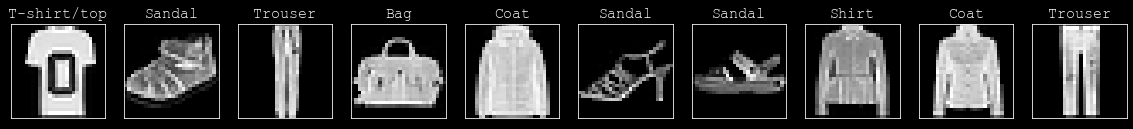

In [3]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The validation set contains {} images, in {} batches".format(len(valid_loader.dataset), len(valid_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))
nsamples = 10
classes_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle boot']
imgs_test, labels = next(iter(train_loader))
fig = plt.figure(figsize=(20,5))
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs_test[i, 0, :, :], vmin=0, vmax=1.0, cmap=matplotlib.cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Basic auto-encoder

We recall here that in order to define an autoencoder, we will need an `encoder`, which compresses the images into a small latent vector, and a `decoder`, that reconstructs the original image from this code. Here, we will start very basic and define the encoder and decoder as simple `Dense` layers. To define the model simply, we will use the [Keras API](https://www.tensorflow.org/guide/keras/custom_layers_and_models) defined in the `tensorflow.keras` module (Note that we pre-loaded the `layers` submodule

In [4]:
class AE(nn.Module):
    def __init__(self, encoding_dim):
        super(AE, self).__init__()
        self.latent_dim = encoding_dim
        self.hidden_dim = 256
        self.encoder = nn.Sequential(
          nn.Linear(28 * 28, self.hidden_dim), nn.ReLU(),
          nn.Linear(self.hidden_dim, self.hidden_dim), nn.ReLU(),
          nn.Linear(self.hidden_dim, self.latent_dim), nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
          nn.Linear(self.latent_dim, self.hidden_dim), nn.ReLU(),
          nn.Linear(self.hidden_dim, self.hidden_dim), nn.ReLU(),
          nn.Linear(self.hidden_dim, 28 * 28), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x.reshape(-1, 28 * 28))
        decoded = self.decoder(encoded)
        return decoded.reshape(-1, 1, 28, 28)

Here we can see that the model depends on a given `encoding_dim` variable, which defines the size of the latent code. Therefore, we can instantiate our model arbitrarliy with `64` dimensions

In [5]:
latent_dim = 64   
model = AE(latent_dim) 

The only remaining part that we did not discuss yet is what type of _loss_ (defined as $\mathcal{L}$) we can use to train our model. First, we will simply rely on the _Mean Squared Error_ (MSE) loss, which is defined as
\begin{equation}
    \mathcal{L}_{MSE}(\hat{\mathbf{x}}, \mathbf{x}) = \mid \hat{\mathbf{x}}, \mathbf{x} \mid^{2}
\end{equation}

In [6]:
# Loss function that we will use
loss_fn = torch.nn.MSELoss(reduction='sum')

<a id="application"> </a>

### Training the model

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [7]:
# Learning rate
learning_rate = 1e-4
# Optimizer to fit the weights of the network
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(20):
    full_loss = torch.Tensor([0])
    # Forward pass: compute predicted y by passing x to the model.
    for i, (x, _) in enumerate(train_loader):
        y_pred = model(x)
        # Compute the loss.
        loss = loss_fn(y_pred, x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Calling the step function to update the parameters
        optimizer.step()
    print(loss)

tensor(5675.9932, grad_fn=<MseLossBackward0>)
tensor(4074.0925, grad_fn=<MseLossBackward0>)
tensor(3881.9771, grad_fn=<MseLossBackward0>)
tensor(3564.0066, grad_fn=<MseLossBackward0>)
tensor(3160.0903, grad_fn=<MseLossBackward0>)
tensor(2828.1121, grad_fn=<MseLossBackward0>)
tensor(2869.4741, grad_fn=<MseLossBackward0>)
tensor(2570.3743, grad_fn=<MseLossBackward0>)
tensor(2457.3076, grad_fn=<MseLossBackward0>)
tensor(2376.8555, grad_fn=<MseLossBackward0>)
tensor(2323.8416, grad_fn=<MseLossBackward0>)
tensor(2240.7024, grad_fn=<MseLossBackward0>)
tensor(2229.1489, grad_fn=<MseLossBackward0>)
tensor(2182.6277, grad_fn=<MseLossBackward0>)
tensor(2156.1914, grad_fn=<MseLossBackward0>)
tensor(2125.0405, grad_fn=<MseLossBackward0>)
tensor(2037.0834, grad_fn=<MseLossBackward0>)
tensor(2029.6140, grad_fn=<MseLossBackward0>)
tensor(2042.3490, grad_fn=<MseLossBackward0>)
tensor(1917.9260, grad_fn=<MseLossBackward0>)


Now that the model is trained, we can test it by encoding and decoding images from the test set.

In [8]:
encoded_imgs = model.encoder(imgs_test.reshape(-1,28*28))
decoded_imgs = model.decoder(encoded_imgs).reshape(-1,28,28).detach().numpy()

By plotting the images, we can see that the model is able to perform an adequate (yet somewhat blurry) reconstruction of the input images. The interesting point is that this reconstruction comes from a code of only `64` dimensions, whereas the original images have `784` dimensions.

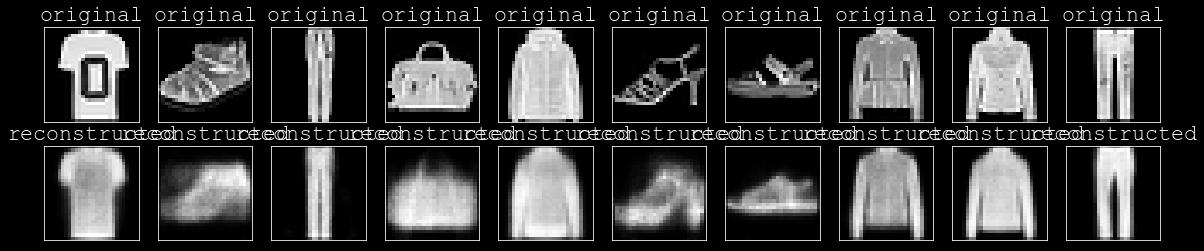

In [9]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(imgs_test[i, 0])
    plt.title("original"); plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed"); plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Improvements

Even though this very basic example seems to work, several improvements can be made over the original model. First, we can see that the overall framework does not depend on the exact nature of the `encoder` and `decoder`. 

***
1. We rewrite the original class to accept any type of architecture for these (see code below). 
2. Fill the missing code to have a new AE model
***

In [22]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, encoding_dim):
        super(AE, self).__init__()
        self.latent_dim = encoding_dim
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.reshape(-1,1,28,28)
        return decoded

######################
'''
class Reshape(nn.Module): 
    def __init__(self, *args): 
        super(Reshape, self).__init__() 
        self.shape = args 
         
    def forward(self, x): 
        return x.view(self.shape) 

def construct_encoder_decoder(input_shape, latent_dim, hidden_dim, output_shape):
    # Encoder network
    encoder = nn.Sequential(
          #nn.Flatten(),
          nn.Linear(input_shape, hidden_dim), 
          Reshape(-1,28*28),
          nn.ReLU(),
          nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
          nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
    )
    # Decoder network
    decoder = nn.Sequential(
          nn.Linear(latent_dim, hidden_dim), nn.ReLU(),
          nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
          nn.Linear(hidden_dim, output_shape), nn.Sigmoid(),
          #Reshape(1,28,28)          
    )
    return encoder, decoder
'''
######################

class Encoder(nn.Module):
    def __init__(self, input_shape, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input_shape = input_shape
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(input_shape, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        x = nn.ReLU()(self.fc1(x.reshape(-1, 28 * 28)))
        x = nn.ReLU()(self.fc2(x))
        x_encode = nn.Sigmoid()(self.fc3(x))
        return x_encode
    

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_shape):
        super(Decoder, self).__init__()
        self.output_shape = output_shape
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_shape)
        
    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x_decode = nn.Sigmoid()(self.fc3(x))
        return x_decode.reshape(-1, 1, 28, 28)



latent_dim = 64
hidden_dim = 256
img_size = 28*28

#encoder, decoder = construct_encoder_decoder(img_size,hidden_dim,latent_dim,img_size)
encoder = Encoder(img_size,hidden_dim,latent_dim)
decoder = Decoder(latent_dim,hidden_dim,img_size)
model = AE(encoder, decoder,latent_dim)

Second, we only used the train dataset, whereas the use of a validation and test sets allows to ensure that we do not overfit our model.

***
1. Write a separate train function, that can be called on different sets
2. Re-write the training loop to test overfitting
***

In [24]:
######################
# Learning rate
learning_rate = 1e-4
# Optimizer to fit the weights of the network
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(20):
    full_loss = torch.Tensor([0])
    # Forward pass: compute predicted y by passing x to the model.
    for i, (x, _) in enumerate(train_loader):
        y_pred = model(x)
        # Compute the loss.
        loss = loss_fn(y_pred, x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Calling the step function to update the parameters
        optimizer.step()
    
    with torch.no_grad():
        for i, (x,_) in enumerate(valid_loader,0):
            # forward and calculate the loss
            y_pred = model(x)
            # Compute the loss
            valid_loss = loss_fn(y_pred,x)
            
    print('epoch: {}'.format(t+1), '| train_loss: {}'.format(loss), '| valid_loss: {}'.format(valid_loss))
######################

epoch: 1 | train_loss: 4728.1826171875 | valid_loss: 3377.00927734375
epoch: 2 | train_loss: 4038.50732421875 | valid_loss: 3399.588134765625
epoch: 3 | train_loss: 3652.517578125 | valid_loss: 2836.024658203125
epoch: 4 | train_loss: 2988.138671875 | valid_loss: 2425.7646484375
epoch: 5 | train_loss: 2803.21044921875 | valid_loss: 2296.773681640625
epoch: 6 | train_loss: 2552.16650390625 | valid_loss: 2042.8253173828125
epoch: 7 | train_loss: 2676.5 | valid_loss: 2243.31787109375
epoch: 8 | train_loss: 2547.62255859375 | valid_loss: 2079.4404296875
epoch: 9 | train_loss: 2492.85009765625 | valid_loss: 2084.994384765625
epoch: 10 | train_loss: 2365.85009765625 | valid_loss: 1952.626220703125
epoch: 11 | train_loss: 2317.473388671875 | valid_loss: 1905.071533203125
epoch: 12 | train_loss: 2271.8291015625 | valid_loss: 1855.13720703125
epoch: 13 | train_loss: 2261.1240234375 | valid_loss: 1812.0244140625
epoch: 14 | train_loss: 2291.6943359375 | valid_loss: 1931.838623046875
epoch: 15 | 

## Exercise: Denoising AE

Imagine (for the sake of argument), that we choose an encoding dimension which is of same dimensionality as the input one. Then, one huge problem is that nothing prevents the AE from simply learning the _identity_ function (try to imagine why). An autoencoder can also be trained to remove noise from images. This type of _regularization_ prevents the model from learning this degenerate situation.

In this exercise, you will need to create your own denoising AE, by relying on a noisy version of the Fashion MNIST dataset (adding random Gaussian noise to each image). You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [25]:
class GaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

Here, we create two new train and test sets by adding random noise to the images

In [26]:
# Load the datasets and use our Gaussian noise transform
train_valid_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir, train=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), GaussianNoise(0., 0.1)]), download=True)
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
test_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), GaussianNoise(0., 0.1)]),train=False)
# Create loaders
train_loader_noisy = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads)
valid_loader_noisy = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
test_loader_noisy = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

Plot the noisy images.


In [27]:
x_test, labels = next(iter(test_loader))
x_test_noisy, labels = next(iter(test_loader_noisy))
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(x_test[i].squeeze())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
    ax = plt.subplot(2, n, i + 1 + n)
    plt.title("original + noise")
    plt.imshow(x_test_noisy[i].squeeze())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
plt.show()

RuntimeError: DataLoader worker (pid(s) 15704, 22172, 1456, 15416) exited unexpectedly

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [38]:
class DenoisingAE(nn.Module):
    def __init__(self,encoder,decoder):
        super(DenoisingAE, self).__init__()
        #self.latent_dim = encoding_dim
        self.encoder = encoder   
        self.decoder = decoder
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(x)
        return decoded
    
encoder = nn.Sequential(
    nn.Conv2d(1,3,(3,3),padding= 1),
    nn.ReLU(),
    nn.Conv2d(3,16,(3,3), padding = 1),
    nn.ReLU(),
    nn.Conv2d(16,32,(3,3), padding =1),
    nn.ReLU(),
)

decoder = nn.Sequential(
    nn.ConvTranspose2d(32,16,(3,3),padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(16,3,(3,3), padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(3,1,(3,3),padding=1),
    nn.ReLU(),
)

autoencoder = DenoisingAE(encoder,decoder)

Write down the full optimization loop to optimize your denoising auto-encoder

In [41]:
######################
# Learning rate
learning_rate = 1e-3
# Optimizer to fit the weights of the network
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss(reduction='sum')

for t in range(20):
    full_loss = torch.Tensor([0])
    # Forward pass: compute predicted y by passing x to the model.
    for i, (x, _) in enumerate(train_loader_noisy):
        y_pred = autoencoder(x)
        # Compute the loss.
        loss = loss_fn(y_pred, x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Calling the step function to update the parameters
        optimizer.step()
    
    with torch.no_grad():
        for i, (x,_) in enumerate(valid_loader_noisy,0):
            # forward and calculate the loss
            y_pred = autoencoder(x)
            # Compute the loss
            valid_loss = loss_fn(y_pred,x)
            
    print('epoch: {}'.format(t+1), '| train_loss: {}'.format(loss), '| valid_loss: {}'.format(valid_loss))
######################

Plot both the noisy images and the denoised images produced by the autoencoder to check that your implementation is correct

In [32]:
######################
x_noisy, labels = next(iter(test_loader_noisy))
######################
encoded_imgs = autoencoder.encoder(x_noisy).detach().numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).detach().numpy()
plt.figure(figsize=(20, 4))
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(x_noisy[i].squeeze())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
    ax = plt.subplot(2, n, i + 1 + n)
    plt.title("decoded")
    plt.imshow(decoded_imgs[i].squeeze())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
plt.show()

<Figure size 1440x288 with 0 Axes>

### References

<a id="reference1"></a>
[1] Rezende, Danilo Jimenez, and Shakir Mohamed. "Variational inference with normalizing flows." _arXiv preprint arXiv:1505.05770_ (2015). [link](http://arxiv.org/pdf/1505.05770)

[2] Kingma, Diederik P., Tim Salimans, and Max Welling. "Improving Variational Inference with Inverse Autoregressive Flow." _arXiv preprint arXiv:1606.04934_ (2016). [link](https://arxiv.org/abs/1606.04934)

[3] Kingma, D. P., & Welling, M. Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114. (2013). [link](https://arxiv.org/pdf/1312.6114)

[4] Rezende, D. J., Mohamed, S., & Wierstra, D. Stochastic backpropagation and approximate inference in deep generative models. arXiv preprint arXiv:1401.4082. (2014). [link](https://arxiv.org/pdf/1401.4082)

[5] Gulrajani, I., Kumar, K., Ahmed, F., Taiga, A. A., Visin, F., Vazquez, D., & Courville, A. (2016). Pixelvae: A latent variable model for natural images. arXiv preprint arXiv:1611.05013. [link](https://arxiv.org/pdf/1611.05013)

[6] Van den Oord, A., & Vinyals, O. (2017). Neural discrete representation learning. In NIPS 2017 (pp. 6306-6315). [link](http://papers.nips.cc/paper/7210-neural-discrete-representation-learning.pdf)